In [15]:
import astropy
from astropy.io import fits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [16]:
data_file = 'high_quality_sample.fits'

with fits.open(data_file) as hdul:
    # Access the first table extension
    data = hdul[1].data
    
    # Convert to DataFrame
    df = pd.DataFrame({col.name: data[col.name].byteswap().newbyteorder() if data[col.name].dtype.byteorder == '>' else data[col.name] for col in data.columns})


pd.set_option('display.max_columns', None)

df.head()

,source_id,l,b,ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ruwe,radial_velocity,radial_velocity_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,catwise_w1,catwise_w2,mh_xgboost,teff_xgboost,logg_xgboost,in_training_sample,col1,col2,Source,RA_ICRS,DE_ICRS,rgeo,b_rgeo_x,B_rgeo_xa,rpgeo,b_rpgeo_x,B_rpgeo_xa,Flag,angDist,fpu,E(B-V)
0,15741055975040,176.739184,-48.572035,45.136038,0.335043,1.439792,0.018947,-0.711280,0.017718,-1.412098,0.016528,1.036041,-0.738894,0.316921,10.254021,10.750235,9.595748,8.152,8.198,-0.144,5065.8,2.993,True,45.136038,0.335043,15741055975040,45.136038,0.335043,695.683899,683.627625,707.396423,696.278320,688.270874,707.143982,10033,0.0,0.013160,0.104689
1,66627828480768,176.483565,-48.171322,45.305053,0.736093,0.534038,0.020692,3.309832,0.022959,1.594356,0.022822,1.349013,41.607450,1.323430,10.508830,11.150953,9.741709,7.891,7.964,-0.401,4499.0,1.916,False,45.305053,0.736093,66627828480768,45.305053,0.736093,1884.275020,1821.247560,1947.302730,1883.143550,1807.318600,1944.665770,10033,0.0,0.038747,0.093026
2,82467667849472,176.209301,-48.607026,44.866246,0.561503,2.209985,0.016049,-4.869755,0.015797,-12.678339,0.013950,1.018742,-32.461674,0.205614,10.651456,11.169626,9.980610,8.496,8.558,0.114,4938.3,3.203,True,44.866246,0.561503,82467667849472,44.866246,0.561503,452.636078,448.701294,456.615540,452.602692,449.257355,455.432892,10033,0.0,0.007262,0.086075
3,101193725229056,175.755174,-48.727781,44.569524,0.689953,0.528788,0.024241,3.539184,0.027864,-1.599436,0.021891,1.176748,91.295900,4.830661,14.332739,14.816101,13.685076,12.220,12.275,-0.478,4980.2,3.319,False,44.569524,0.689953,101193725229056,44.569524,0.689953,1908.478270,1815.024170,2014.483890,1868.603880,1800.940800,1949.831300,10033,0.0,0.045842,0.078062
4,130399502833792,175.789759,-48.328584,44.868872,0.955080,0.847929,0.017479,3.382907,0.017619,-0.291235,0.015982,1.087555,1.959265,0.328298,11.215295,11.810178,10.481738,8.728,8.815,-0.159,4643.6,2.398,True,44.868872,0.955080,130399502833792,44.868872,0.955080,1178.407470,1155.319820,1203.711180,1177.687260,1154.219600,1201.322750,10033,0.0,0.020614,0.077163


In [17]:
df.shape

(3483206, 38)

In [25]:
df['distance_kpc'] = df['rgeo']

# Replace infinite values caused by zero parallax with NaN
df['distance_kpc'].replace([float('inf'), -float('inf')], pd.NA, inplace=True)

# Inspect the first few rows
print(df[['source_id', 'parallax', 'distance_kpc']].head())

         source_id  parallax  distance_kpc
0   15741055975040  1.439792      0.695684
1   66627828480768  0.534038      1.884275
2   82467667849472  2.209985      0.452636
3  101193725229056  0.528788      1.908478
4  130399502833792  0.847929      1.178407


/var/folders/p3/pkt6pdhs7fq9ksxkhmbp2_xr0000gn/T/ipykernel_1567/1122305782.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['distance_kpc'].replace([float('inf'), -float('inf')], pd.NA, inplace=True)


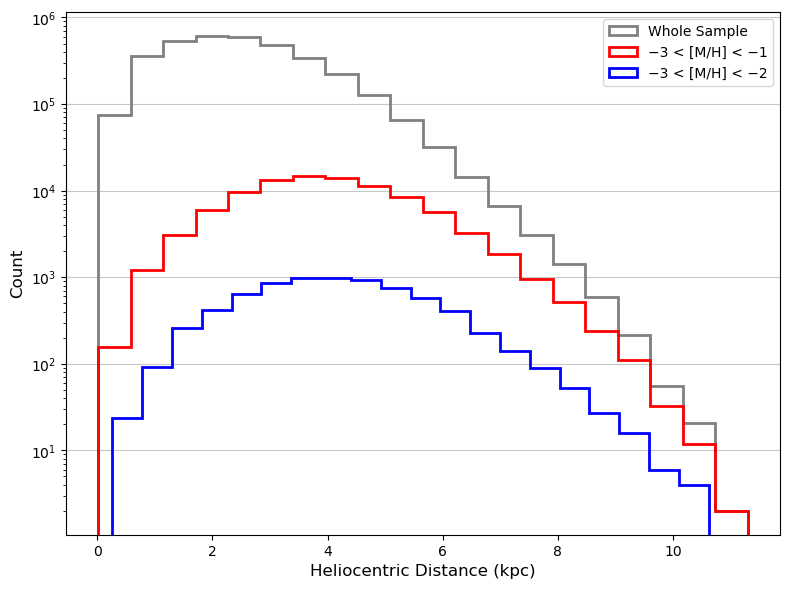

In [71]:
distance_col = 'distance_kpc'
mh_col = 'mh_xgboost'

# Subset the data based on [M/H] ranges
subset_mh_neg1 = df[(df[mh_col] > -3) & (df[mh_col] < -1)]
subset_mh_neg2 = df[(df[mh_col] > -3) & (df[mh_col] < -2)]

# Plot the histogram for the whole sample
plt.figure(figsize=(8, 6))
plt.hist(
    df[distance_col],
    bins=20,
    histtype='step',
    color='grey',
    linewidth=2,
    label='Whole Sample'
)

# Plot the histogram for the subset with -3 < [M/H] < -1
plt.hist(
    subset_mh_neg1[distance_col],
    bins=20,
    histtype='step',
    color='red',
    linewidth=2,
    label='−3 < [M/H] < −1'
)

# Plot the histogram for the subset with -3 < [M/H] < -2
plt.hist(
    subset_mh_neg2[distance_col],
    bins=20,
    histtype='step',
    color='blue',
    linestyle='-',
    linewidth=2,
    label='−3 < [M/H] < −2'
)

# Set logarithmic scale for y-axis
plt.yscale('log')

# Add title and labels
plt.xlabel('Heliocentric Distance (kpc)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle='-', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


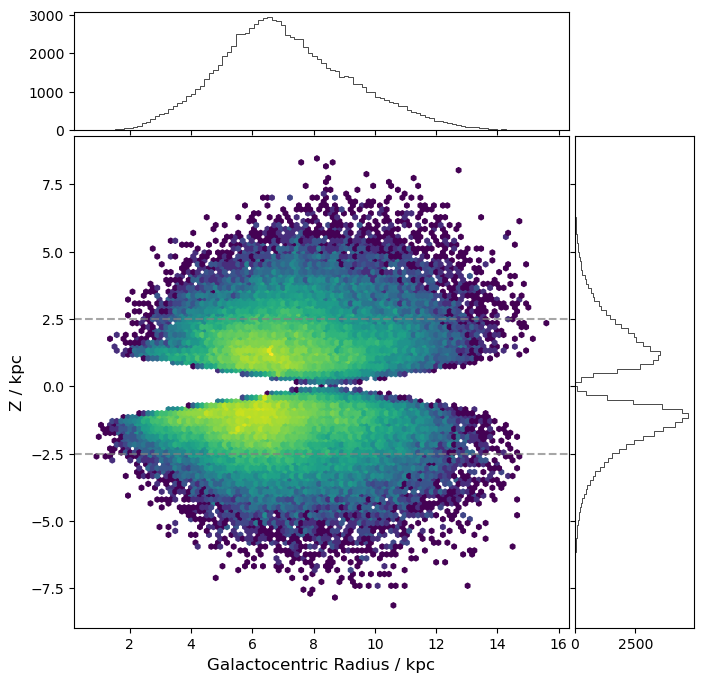

In [57]:
# Galactic constants
z_sun = 0.025  # Sun's height above Galactic plane in kpc
r_sun = 8.5  # Distance of Sun from Galactic centre in kpc

# Calculate z (height above/below Galactic plane)
df['z'] = df['distance_kpc'] * np.sin(np.radians(df['b'])) + z_sun

# Calculate R (Galactocentric cylindrical radius)
df['R'] = np.sqrt(
    (df['distance_kpc'] * np.cos(np.radians(df['b']))) ** 2 + r_sun ** 2
    - 2 * df['distance_kpc'] * np.cos(np.radians(df['b'])) * r_sun * np.cos(np.radians(df['l']))
)

# Filter stars with -3 < [M/H] < -1
metallicity_range = (-3, -1)
df_filtered = df[(df['mh_xgboost'] > metallicity_range[0]) & (df['mh_xgboost'] < metallicity_range[1])]

# Create the main figure
fig = plt.figure(figsize=(8, 8))
grid = plt.GridSpec(5, 5, hspace=0.05, wspace=0.05)

# Main z-R plot
main_ax = fig.add_subplot(grid[1:, :-1])
# Top histogram
x_hist = fig.add_subplot(grid[0, :-1], sharex=main_ax)
# Right histogram
y_hist = fig.add_subplot(grid[1:, -1], sharey=main_ax)

# Scatter plot for the star density with a colormap that emphasises yellow
sc = main_ax.hexbin(
    df_filtered['R'], df_filtered['z'], 
    gridsize=100, cmap='viridis', mincnt=1, norm=LogNorm()
)

# Add translucent lines around grey boxes
main_ax.axhline(-2.5, color='grey', linestyle='--', alpha=0.7)
main_ax.axhline(2.5, color='grey', linestyle='--', alpha=0.7)

# Add histograms
x_hist.hist(df_filtered['R'], bins=100, color='black', histtype='step', linewidth=0.5)
y_hist.hist(df_filtered['z'], bins=100, orientation='horizontal', color='black', histtype='step', linewidth=0.5)

# Hide spines and ticks for the histograms
x_hist.spines['right'].set_visible(True)
x_hist.spines['top'].set_visible(True)
x_hist.tick_params(axis="x", labelbottom=False)

y_hist.spines['right'].set_visible(True)
y_hist.spines['top'].set_visible(True)
y_hist.tick_params(axis="y", labelleft=False)

# Set labels and titles
main_ax.set_xlabel("Galactocentric Radius / kpc", fontsize=12)
main_ax.set_ylabel("Z / kpc", fontsize=12)

plt.show()

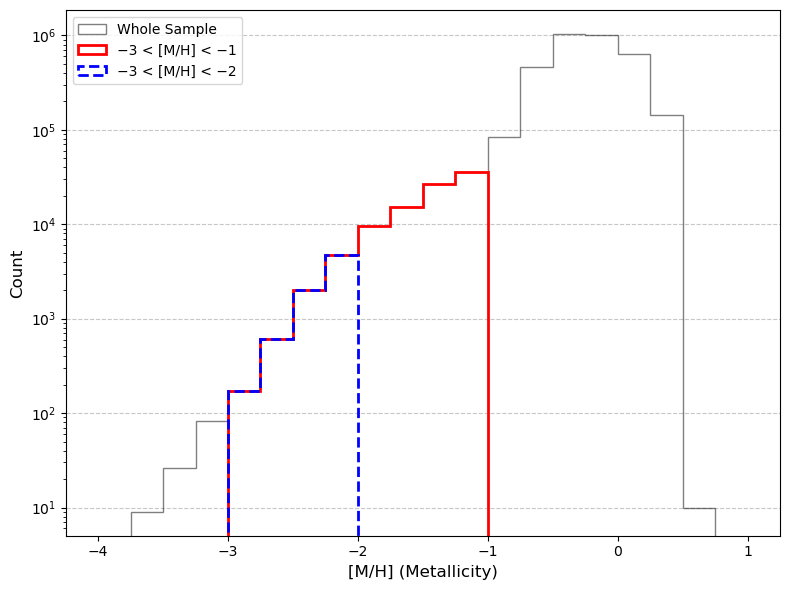

In [72]:
mh_col = 'mh_xgboost'

# Filter subsets of the data for specific metallicity ranges
subset_mh_neg1 = df[(df[mh_col] > -3) & (df[mh_col] < -1)]
subset_mh_neg2 = df[(df[mh_col] > -3) & (df[mh_col] < -2)]

# Define common bins from -4 to 1 with step size of 0.25
bins = np.arange(-4, 1 + 0.25, 0.25)  # Bins from -4 to 1 with 0.25 step size

# Plot the metallicity distribution
plt.figure(figsize=(8, 6))

# Whole sample
plt.hist(
    df[mh_col], bins=bins, color='grey', alpha=0.5, histtype='step', edgecolor='black',
    label='Whole Sample', density=False
)

# Subset with -3 < [M/H] < -1
plt.hist(
    subset_mh_neg1[mh_col], bins=bins, histtype='step', color='red', linestyle='-', linewidth=2,
    label='−3 < [M/H] < −1', density=False
)

# Subset with -3 < [M/H] < -2
plt.hist(
    subset_mh_neg2[mh_col], bins=bins, histtype='step', color='blue', linestyle='--', linewidth=2,
    label='−3 < [M/H] < −2', density=False
)

# Add labels, title, and legend
plt.xlabel('[M/H] (Metallicity)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Log scale for y-axis
plt.yscale('log')

# Show the plot
plt.tight_layout()
plt.show()

